In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
batch_size = 128
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.RandomCrop(32, padding=4, padding_mode='constant')])

data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_indices = list(range(len(data)))[:45000]
validation_indices = list(range(len(data)))[45000:]

# train_sample = torch.utils.data.SubsetRandomSampler(train_indices)
# validation_sample = torch.utils.data.SubsetRandomSampler(validation_indices)


# Subsets of the whole train data using the sampled indices
trainset = torch.utils.data.Subset(data, train_indices)
validationset = torch.utils.data.Subset(data, validation_indices)

# Dataloader using the created subsets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(validationset)

5000

In [4]:
print('Train set size: ', len(trainloader) * 4)
print('Validation set size: ', len(validationloader) * 4)
print('Test set size: ', len(testloader) * 4)

Train set size:  1408
Validation set size:  160
Test set size:  316


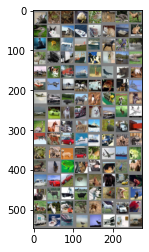

  cat  frog  frog  frog  bird   dog  bird horse  bird   cat horse  ship  ship   cat  ship  frog   cat  deer plane plane  ship horse  bird  ship  deer  frog truck  ship   dog  bird  ship  deer plane   cat truck  ship  deer  bird   cat horse  ship plane plane horse truck  frog   dog plane plane  ship  bird horse  bird truck   dog  bird plane   car   dog truck   dog  ship  deer plane  bird horse truck   cat  ship  bird truck truck   cat  deer   car plane  ship   car  deer   cat  frog  frog   dog   car  deer plane  ship  frog  deer   cat  frog   cat   cat   cat  bird horse  ship   car   car  frog   dog   dog   car  frog   cat  deer truck  bird horse  bird  bird  deer  deer horse horse  deer  deer horse   car  bird truck  ship  ship  bird  deer plane  deer   car


In [5]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

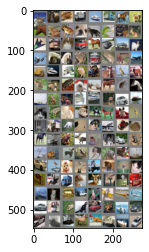

 deer horse  frog truck  ship truck horse   dog horse  frog  frog   dog   cat  frog   cat  deer plane truck   dog   car horse   car plane   dog plane   cat horse  frog truck  frog  deer plane truck  ship truck  frog truck horse  bird horse   cat   dog  frog  bird  ship horse  deer horse  ship  frog truck  frog  ship  deer   car  ship   cat  frog   dog  ship horse horse   dog  bird  deer truck   cat   cat   dog plane truck  frog horse  ship  frog  deer  bird   dog   car  frog plane  bird   dog  bird   dog  frog   dog  ship   car  bird   dog  bird truck   dog  bird   cat   cat truck truck   cat  deer  deer  bird truck  ship   cat  deer truck  frog plane  ship plane   car   dog   dog   cat   car  frog  ship   car   car  ship  deer horse plane truck  ship   car


In [6]:
# Get some random valldation images.
dataiter = iter(validationloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [7]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [8]:
class NetMod(nn.Module):
    def __init__(self):
        super(NetMod, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=(8,8))
        
        self.filter1 = 16
        self.filter2 = 32
        self.filter3 = 64
        
        self.convinit = nn.Conv2d(in_channels=3, out_channels=self.filter1, kernel_size=3, stride=1, padding=1)
        
        self.conv1 = nn.Conv2d(in_channels=self.filter1, out_channels=self.filter1, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.filter1, out_channels=self.filter1, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=self.filter1, out_channels=self.filter1, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.filter1, out_channels=self.filter1, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=self.filter1, out_channels=self.filter1, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=self.filter1, out_channels=self.filter1, kernel_size=3, stride=1, padding=1)
        self.projection1 = nn.Conv2d(in_channels=self.filter1, out_channels=self.filter2, kernel_size=1, stride=2)
        
        self.conv7 = nn.Conv2d(in_channels=self.filter1, out_channels=self.filter2, kernel_size=3, stride=2, padding=1)
        self.conv8 = nn.Conv2d(in_channels=self.filter2, out_channels=self.filter2, kernel_size=3, stride=1, padding=1)
        self.conv9 = nn.Conv2d(in_channels=self.filter2, out_channels=self.filter2, kernel_size=3, stride=1, padding=1)
        self.conv10 = nn.Conv2d(in_channels=self.filter2, out_channels=self.filter2, kernel_size=3, stride=1, padding=1)
        self.conv11 = nn.Conv2d(in_channels=self.filter2, out_channels=self.filter2, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(in_channels=self.filter2, out_channels=self.filter2, kernel_size=3, stride=1, padding=1)
        self.projection2 = nn.Conv2d(in_channels=self.filter2, out_channels=self.filter3, kernel_size=1, stride=2)
        
        self.conv13 = nn.Conv2d(in_channels=self.filter2, out_channels=self.filter3, kernel_size=3, stride=2, padding=1)
        self.conv14 = nn.Conv2d(in_channels=self.filter3, out_channels=self.filter3, kernel_size=3, stride=1, padding=1)
        self.conv15 = nn.Conv2d(in_channels=self.filter3, out_channels=self.filter3, kernel_size=3, stride=1, padding=1)
        self.conv16 = nn.Conv2d(in_channels=self.filter3, out_channels=self.filter3, kernel_size=3, stride=1, padding=1)
        self.conv17 = nn.Conv2d(in_channels=self.filter3, out_channels=self.filter3, kernel_size=3, stride=1, padding=1)
        self.conv18 = nn.Conv2d(in_channels=self.filter3, out_channels=self.filter3, kernel_size=3, stride=1, padding=1)
        
        self.batchnorminit = nn.BatchNorm2d(self.filter1)
        self.batchnorm1 = nn.BatchNorm2d(self.filter1)
        self.batchnorm2 = nn.BatchNorm2d(self.filter1)
        self.batchnorm3 = nn.BatchNorm2d(self.filter1)
        self.batchnorm4 = nn.BatchNorm2d(self.filter1)
        self.batchnorm5 = nn.BatchNorm2d(self.filter1)
        self.batchnorm6 = nn.BatchNorm2d(self.filter1)
        self.batchnorm7 = nn.BatchNorm2d(self.filter2)
        self.batchnorm8 = nn.BatchNorm2d(self.filter2)
        self.batchnorm9 = nn.BatchNorm2d(self.filter2)
        self.batchnorm10 = nn.BatchNorm2d(self.filter2)
        self.batchnorm11 = nn.BatchNorm2d(self.filter2)
        self.batchnorm12 = nn.BatchNorm2d(self.filter2)
        self.batchnorm13 = nn.BatchNorm2d(self.filter3)
        self.batchnorm14 = nn.BatchNorm2d(self.filter3)
        self.batchnorm15 = nn.BatchNorm2d(self.filter3)
        self.batchnorm16 = nn.BatchNorm2d(self.filter3)
        self.batchnorm17 = nn.BatchNorm2d(self.filter3)
        self.batchnorm18 = nn.BatchNorm2d(self.filter3)
        
        
        self.fc1 = nn.Linear(in_features=self.filter3, out_features=10)
        
    def forward(self, x):
        ##### n = 3
        ##### first 3x3 conv layer
        x = self.convinit(x)
        x = self.batchnorminit(x)
        x = F.relu(x)
        
        ##### 2n layers for 32x32 features
        x1 = self.conv1(x)
        x1 = self.batchnorm1(x1)
        x1 = F.relu(x1)
        
        x2 = self.conv2(x1)
        x2 = self.batchnorm2(x2)
        x2 = x2 + x1
        x2 = F.relu(x2)
        
        x3 = self.conv3(x2)
        x3 = self.batchnorm3(x3)
        x3 = F.relu(x3)
        
        x4 = self.conv4(x3)
        x4 = self.batchnorm4(x4)
        x4 = x4 + x2
        x4 = F.relu(x4)
        
        x5 = self.conv5(x4)
        x5 = self.batchnorm5(x5)
        x5 = F.relu(x5)
        
        x6 = self.conv6(x5)
        x6 = self.batchnorm6(x6)
        x6 = x6 + x4
        x6 = F.relu(x6)
        
        ##### 2n layers for 16x16 features
        x7 = self.conv7(x6)
        x7 = self.batchnorm7(x7)
        x7 = F.relu(x7)
        
        x8 = self.conv8(x7)
        x8 = self.batchnorm8(x8)
        x8 = x8 + self.projection1(x6)
        x8 = F.relu(x8)
        
        x9 = self.conv9(x8)
        x9 = self.batchnorm9(x9)
        x9 = F.relu(x9)
        
        x10 = self.conv10(x9)
        x10 = self.batchnorm10(x10)
        x10 = x10 + x8
        x10 = F.relu(x10)
        
        x11 = self.conv11(x10)
        x11 = self.batchnorm11(x11)
        x11 = F.relu(x11)
        
        x12 = self.conv12(x11)
        x12 = self.batchnorm12(x12)
        x12 = x12 + x10
        x12 = F.relu(x12)
        
        #### 2n layers for 8x8 features
        x13 = self.conv13(x12)
        x13 = self.batchnorm13(x13)
        x13 = F.relu(x13)
        
        x14 = self.conv14(x13)
        x14 = self.batchnorm14(x14)
        x14 = x14 + self.projection2(x12)
        x14 = F.relu(x14)
        
        x15 = self.conv15(x14)
        x15 = self.batchnorm15(x15)
        x15 = F.relu(x15)
        
        x16 = self.conv16(x15)
        x16 = self.batchnorm16(x16)
        x16 = x16 + x14
        x16 = F.relu(x16)
        
        x17 = self.conv17(x16)
        x17 = self.batchnorm17(x17)
        x17 = F.relu(x17)
        
        x18 = self.conv18(x17)
        x18 = self.batchnorm18(x18)
        x18 = x18 + x16
        x18 = F.relu(x18)
        
        # avg pool and linear layer
        x19 = self.avgpool(x18)
        x19 = torch.flatten(x19, 1)
        x19 = self.fc1(x19)
        return x19

net = NetMod()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

NetMod(
  (avgpool): AvgPool2d(kernel_size=(8, 8), stride=(8, 8), padding=0)
  (convinit): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (projection1): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
  (conv7): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (con

In [9]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=2, threshold=0.01, min_lr=0.00001, verbose=True)

In [10]:
avg_losses = []   # Avg. losses.
epochs = 30       # Total epochs.
print_freq = 100  # Print frequency.
lr_list = set()
valid_losses = []
train_losses = []

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    validation_loss = 0.0
    train_loss = 0.0
    
    net.train()
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        train_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq    
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

    net.eval()
    with torch.no_grad():
        for i, data in enumerate(validationloader, 0):
            # Get the inputs.
            inputs, labels = data

            # Move the inputs to the specified device.
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward step.
            outputs = net(inputs)
            loss = loss_func(outputs, labels)
            validation_loss += loss.item()
    net.train()
    
    # If validation error no longer improve, divide the lr by 10
    scheduler.step(validation_loss)
    print('Validation Loss: ', validation_loss, '----', 'Train Loss: ', train_loss)
    valid_losses.append(validation_loss)
    train_losses.append(train_loss)
    lr_list.add(scheduler._last_lr[0])
                            

print('Finished Training.')
print('LR list: ', lr_list)

[epoch: 0, i:    99] avg mini-batch loss: 1.9634444963932038
[epoch: 0, i:   199] avg mini-batch loss: 1.6679569101333618
[epoch: 0, i:   299] avg mini-batch loss: 1.5379667270183563
Validation Loss:  61.80677604675293 ---- Train Loss:  590.3566126823425
[epoch: 1, i:    99] avg mini-batch loss: 1.3619616866111754
[epoch: 1, i:   199] avg mini-batch loss: 1.2244957691431047
[epoch: 1, i:   299] avg mini-batch loss: 1.15067067861557
Validation Loss:  48.61713659763336 ---- Train Loss:  429.1227779388428
[epoch: 2, i:    99] avg mini-batch loss: 1.0177958929538726
[epoch: 2, i:   199] avg mini-batch loss: 0.9821865099668503
[epoch: 2, i:   299] avg mini-batch loss: 0.924144771695137
Validation Loss:  50.63099426031113 ---- Train Loss:  338.49999165534973
[epoch: 3, i:    99] avg mini-batch loss: 0.874959265589714
[epoch: 3, i:   199] avg mini-batch loss: 0.8276510483026505
[epoch: 3, i:   299] avg mini-batch loss: 0.8027059674263001
Validation Loss:  32.32177835702896 ---- Train Loss:  2

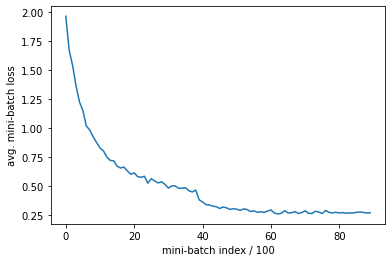

In [11]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

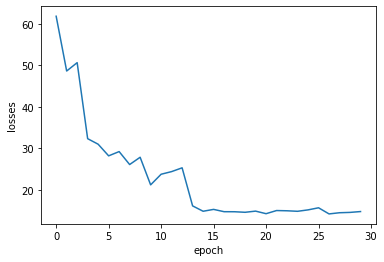

In [12]:
plt.plot(valid_losses)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.show()

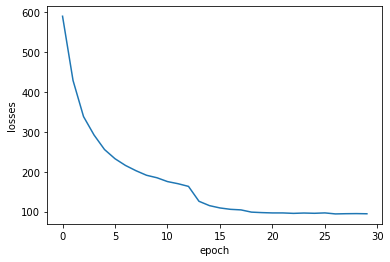

In [13]:
plt.plot(train_losses)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.show()

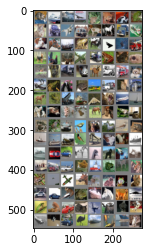

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  bird  deer   car truck   dog  deer  frog   dog  frog plane truck   cat truck horse  frog truck  ship plane   cat  ship  ship horse horse  deer  frog horse   cat  frog   cat  frog  bird   car  bird   cat horse  bird  frog  ship  ship plane  bird truck   cat   cat  ship  ship   car   car horse  bird   dog  bird horse  ship truck plane   cat  ship  frog  deer  frog  frog plane plane horse  deer   dog  frog   cat   car   car   cat  frog  ship horse  deer plane  frog  bird   car   cat plane  deer  bird horse  ship   cat   car  bird  ship plane  ship   cat
Predicted:    cat  ship  ship  ship  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck  deer  bird   cat plane truck  frog  frog   dog  deer   dog tr

NetMod(
  (avgpool): AvgPool2d(kernel_size=(8, 8), stride=(8, 8), padding=0)
  (convinit): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (projection1): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
  (conv7): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (con

In [14]:
# Check several images.
net.eval()
with torch.no_grad():
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
    outputs = net(images.to(device))
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(batch_size)))
net.train()

In [15]:
# Get test accuracy.
correct = 0
total = 0

net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
#         print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
#         print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
#                               for j in range(batch_size)))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

net.train()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 87 %


In [16]:
total

10000

In [17]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(batch_size):
            if i == len(labels):
                break
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 90 %
Accuracy of   car : 94 %
Accuracy of  bird : 80 %
Accuracy of   cat : 71 %
Accuracy of  deer : 87 %
Accuracy of   dog : 79 %
Accuracy of  frog : 90 %
Accuracy of horse : 89 %
Accuracy of  ship : 92 %
Accuracy of truck : 90 %
